In [3]:
%load_ext autoreload
%autoreload 2

from Shared.shared import *
from Shared.specific_CNB_sim import *

sim_name = f"no_gravity"
sim_folder = f"sim_output/{sim_name}"
fig_folder = f"figures_local/{sim_name}"
Cl_folder = f"Shared/Cls"
Delta_folder = f"Shared/Deltas"
nu_m_range = jnp.load(f"{sim_folder}/neutrino_massrange_eV.npy")
nu_m_picks = jnp.array([0.01, 0.05, 0.1, 0.2, 0.3])*Params.eV
simdata = SimData(sim_folder)

# Fermi-Dirac distribution assumption
# note: total densities are computed for length 50 mass range
pix_dens_FD = jnp.load(f"{sim_folder}/pixel_densities.npy")
tot_dens_FD = jnp.load(f"{sim_folder}/total_densities_0.1T_d.npy")
print(pix_dens_FD.shape)
print(tot_dens_FD.shape)

# Deltas_halos = jnp.load(f"{sim_folder}/Deltas_halos.npy")
# print(Deltas_halos.shape)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(1, 5)
(1, 50)


## Monopole perturbation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(1, 50)
(50,)
[0.99980662 0.99991533 0.99996537 0.99998683 0.99999537 0.9999985
 0.99999956 0.99999988 0.99999997 0.99999999 1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 0.99999999 0.99999999 0.99999999 0.99999999 0.99999999 0.99999998
 0.99999998 0.99999997 0.99999997 0.99999996 0.99999995 0.99999994
 0.99999993 0.99999991]


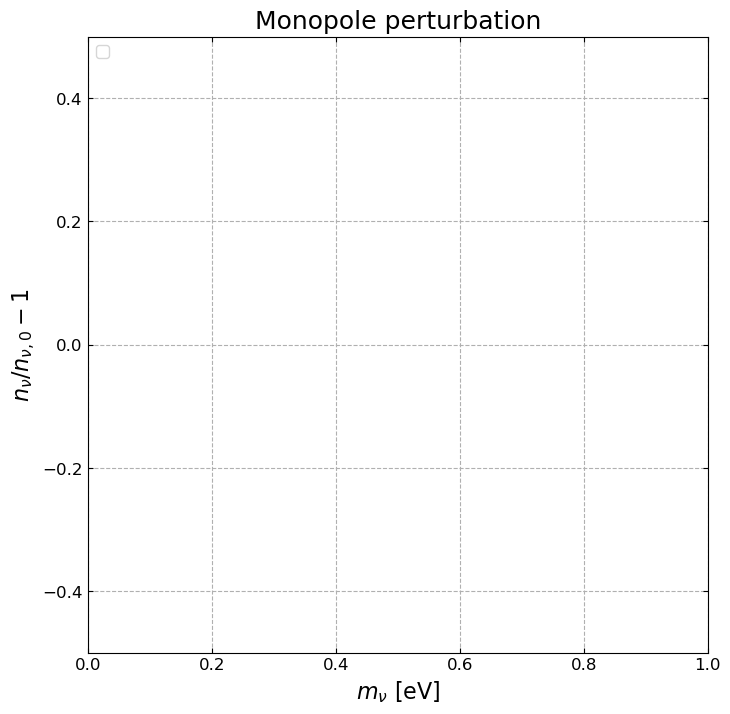

In [6]:
colors = ["mediumblue"]
labels = ["Fermi-Dirac"]

fig_paths = [
    f"{fig_folder}/overdensity_band_{sim_name}_linear.pdf",
    f"{fig_folder}/overdensity_band_{sim_name}_linear.png"
]

eta = 5*1e-1
print(np.shape(tot_dens_FD))
print(np.shape(nu_m_range))
SimPlot.overdensity_band_decay(
    dens_FD=tot_dens_FD,
    m_arr_FD=nu_m_range,
    colors=colors,
    labels=labels,
    plot_xlims=None,
    plot_ylims=((0-eta),(0+eta)),
    plot_log=False,
    fig_paths=fig_paths,
    args=Params())

## CNB anisotropy x DM line-of-sight skymaps

(768, 1000, 2, 6)


ic| CNB_dens_1mass.shape: (768,)
ic| CNB_dens_1mass.min(): Array(0.07370979, dtype=float64)
    CNB_dens_1mass.max(): Array(0.07370979, dtype=float64)


<class 'jaxlib.xla_extension.ArrayImpl'>


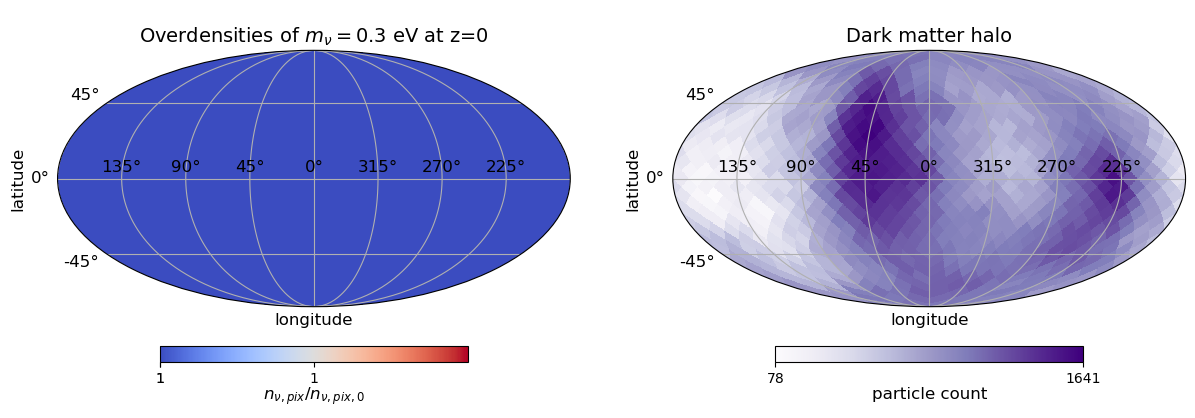

In [3]:
nu_vectors = jnp.load(f"{sim_folder}/vectors_halo1.npy")
print(nu_vectors.shape)

nu_dens = Physics.number_densities_all_sky(
    v_arr=nu_vectors[..., 3:],
    m_arr=nu_m_range,
    pix_sr=simdata.pix_sr,
    args=Params())

# Choose which halo to plot
halo_i = 1

# Load associated origID of chosen halo
halo_indices = jnp.load(
    f"{sim_folder}/halo_batch_0.6-2.0x1e+12.0_Msun_indices.npy")
haloID = halo_indices[halo_i-1]

# Choose which neutrino mass to plot
m_val = 0.3
m_idx = jnp.abs(nu_m_range - m_val).argmin()

# Load corresponding number densities
CNB_dens_1mass = nu_dens[m_idx]
ic(CNB_dens_1mass.shape)
ic(CNB_dens_1mass.min(), CNB_dens_1mass.max())

fig_paths = [
    f"{fig_folder}/skymaps_CNBxDM_{sim_name}.pdf",
    f"{fig_folder}/skymaps_CNBxDM_{sim_name}.png",
]

print(
    # m_val.shape,
    type(CNB_dens_1mass),

)

CNB_skymap, DM_halo_skymap = SimPlot.skymaps_CNBxDM(
    nu_mass=m_val, 
    CNB_dens=CNB_dens_1mass, 
    DM_halo_pos=jnp.load(f"Data/halo_grids/DM_pos_origID{haloID}_snap_0036.npy"), 
    init_xyz=jnp.load(f"{sim_folder}/init_xyz_halo{halo_i}.npy"), 
    fig_paths=fig_paths,
    args=Params())

## Power spectra

Input array must have shape (halos, masses, Npix). Here: (1, 5, 768)


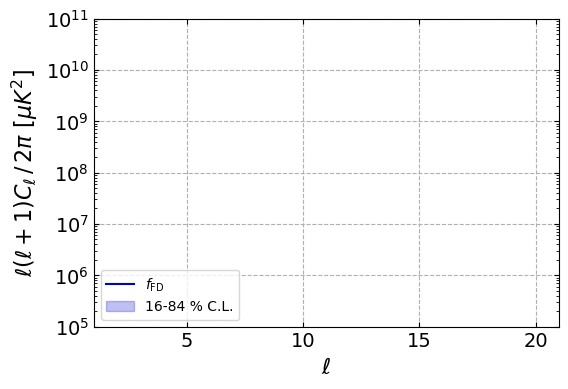

In [16]:
def power_spectra_FDxPF_decay(
    m_pick, pix_dens_FD, y_lims, sim_dir, fig_dir, args):
    
    m_specs = jnp.array([0.01, 0.05, 0.1, 0.2, 0.3])*args.eV
    m_range = jnp.load(f"{sim_dir}/neutrino_massrange_eV.npy")

    mPF_i = jnp.abs(m_specs - m_pick).argmin()
    # mFD_i = jnp.abs(m_range - m_pick).argmin()
    mFD_i = jnp.abs(m_specs - m_pick).argmin()

    halo_num = len(pix_dens_FD)

    power_spectra_FD_l = []
    for halo_i in range(halo_num):

        m_nu = m_specs[mFD_i]

        FD_skymap = pix_dens_FD[halo_i, mFD_i]

        # Convert maps of neutrino densities to temperatures.
        cm3 = args.cm**3
        FD_Tmap = np.cbrt((FD_skymap*(1/cm3)*4*args.Pi**2) / (args.g_nu*3*zeta(3)))

        T_unit = args.muK
        FD_Tmap /= T_unit

        # Compute power spectrum of number density all-sky map.
        cl_FD = hp.sphtfunc.anafast(FD_Tmap, lmax=None)

        ell = jnp.arange(len(cl_FD))

        # Unit to compare to similar figures in literature.
        # scaling = Primordial.Cl_scaling
        scaling = 1  # if Tmaps already in muK
        
        power_spectrum_FD = ell * (ell+1) * cl_FD * scaling / (2*args.Pi)

        power_spectra_FD_l.append(power_spectrum_FD)


    # Convert lists to arrays
    power_spectra_FD = jnp.array(power_spectra_FD_l)

    # Compute median and percentile ranges for Fermi-Dirac spectra
    power_median_FD = jnp.median(power_spectra_FD, axis=0)
    power_perc2p5_FD = jnp.percentile(power_spectra_FD, q=2.5, axis=0)
    power_perc97p5_FD = jnp.percentile(power_spectra_FD, q=97.5, axis=0)
    power_perc16_FD = jnp.percentile(power_spectra_FD, q=16, axis=0)
    power_perc84_FD = jnp.percentile(power_spectra_FD, q=84, axis=0)

    fig = plt.figure(figsize =(6, 4))
    fig.tight_layout()
    ax1 = fig.add_subplot(111)

    FD_color = "mediumblue"
    ax1.semilogy(
        ell, power_median_FD, color=FD_color, 
        label=r"$f_{\rm FD}$")
    # ax1.fill_between(
    #     ell, power_perc2p5_FD, power_perc97p5_FD, 
    #     color=FD_color, alpha=0.15, label='2.5-97.5 % C.L.')
    ax1.fill_between(
        ell, power_perc16_FD, power_perc84_FD, 
        color=FD_color, alpha=0.25, label='16-84 % C.L.')
    

    # ax1.set_title(fr"Power spectra comparison $m_\nu = ${m_pick} eV")
    ax1.set_xlabel("$\ell$")
    # ax1.set_xlim(1,np.max(ell))
    ax1.set_xlim(1,21)
    ax1.set_ylabel(r"$\ell(\ell+1)C_{\ell} \, / \, 2\pi \,\, [\mu K^2]$")

    if y_lims is not None:
        ax1.set_ylim(y_lims[0], y_lims[1])

    ax1.grid(True, which="major", linestyle="dashed")
    ax1.legend(loc='lower left', prop={'size':10})

    plt.savefig(
        f"{fig_dir}/power_spectra_FD_vs_PF_decay_{m_pick}eV.pdf", 
        bbox_inches="tight")
    plt.savefig(
        f"{fig_dir}/power_spectra_FD_vs_PF_decay_{m_pick}eV.png", 
        bbox_inches="tight")
    plt.show(); plt.close()


N0_pix = Params.N0 / simdata.Npix
skymap_norm = N0_pix / (Params.cm**-3)
print(f"Input array must have shape (halos, masses, Npix). Here:", pix_dens_FD.shape)
for m_pick in nu_m_picks[2:3]:
    power_spectra_FDxPF_decay(
        m_pick=m_pick, 
        pix_dens_FD=pix_dens_FD - skymap_norm, 
        # y_lims=None,
        y_lims=(1e5, 1e11),
        sim_dir=sim_folder, 
        fig_dir=fig_folder,
        args=Params())